In [1]:
import Drone
from configurations import defaultConfig 
import numpy as np
from plottingFunctions import open_loop_plots
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from rrtplanner import RRTStar, plot_rrt_lines, plot_path, plot_og, plot_start_goal
import ConvexMotionPlanning

## Testing occupency grid generation
Significantly increase the number of obstacles to check that they are being registered correctly

Text(0, 0.5, 'Vertical distance (m)')

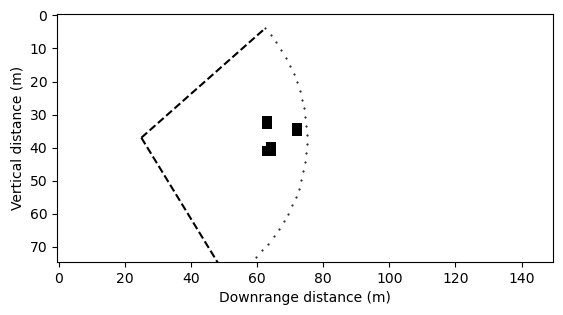

In [2]:
importlib.reload(Drone)

config = defaultConfig()
config.numObstacles = 25
drone = Drone.Drone(config, config)

thrustCommand = 4.4
fpaCommand = 0/180*np.pi
dynRef = drone.coherentCommand(thrustCommand,fpaCommand)
elivatorRef = drone.elevatorFromAlpha(dynRef[1]-dynRef[3])
stateRef = np.hstack(([0,50], dynRef))
action = (thrustCommand, elivatorRef, dynRef)
drone.reset(stateRef)

observation, grid, reward, terminated = drone.step(action)


# random data
fig, ax = plt.subplots()

# define the colors
cmap = mpl.colors.ListedColormap(['w', 'k'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
x = drone.ogOrigin[0]
z = drone.ogOrigin[1]
theta = drone.plant.state[3]
beam = drone.lidar_range
angle = drone.lidar_angle
res = drone.lidar_res
ax.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--')
ax.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--')
a = np.linspace(-angle/2,angle/2,int(res/3))
xs = x+beam*np.cos(theta+a)
zs = z+beam*np.sin(theta+a)
ax.plot(xs,zs,'k.',markersize=1)

ax.imshow(grid, interpolation='none', cmap=cmap, norm=norm)
ax.set_xlabel("Downrange distance (m)")
ax.set_ylabel("Vertical distance (m)")


# RRT Test

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Text(0, 0.5, 'Downrange distance (m)')

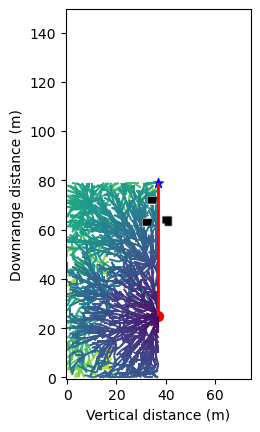

In [3]:
midpoint = drone.ogOrigin[1]
lookAhead = 54
orignX = drone.ogOrigin[0]
xstart = np.array([midpoint, orignX]) 
xgoal = np.array([midpoint, orignX+lookAhead])
n = 3000
r_rewire = 5
rrts = RRTStar(grid[0:midpoint+1, 0:80], n, r_rewire, pbar = False) 
T, gv = rrts.plan(xstart, xgoal)
path = rrts.route2gv(T, gv)
path_pts = rrts.vertices_as_ndarray(T, path)
tEnd = 450
fig = plt.figure()
ax = fig.add_subplot()

#these functions alter ax in-place.
plot_og(ax, grid)
plot_start_goal(ax, xstart, xgoal)
plot_rrt_lines(ax, T)
plot_path(ax, path_pts)
ax.set_xlabel("Vertical distance (m)")
ax.set_ylabel("Downrange distance (m)")


## Trajectory Refignment

     pcost       dcost       gap    pres   dres
 0: -9.3105e+04 -9.6821e+05  1e+06  4e-01  7e-10
 1: -3.6996e+04 -6.3928e+05  7e+05  6e-02  1e-10
 2: -4.8985e+04 -3.4001e+05  3e+05  1e-02  3e-11
 3: -4.7869e+04 -3.2829e+05  3e+05  1e-02  2e-11
 4: -4.8342e+04 -1.1477e+05  7e+04  2e-03  4e-12
 5: -4.8194e+04 -8.3664e+04  4e+04  5e-04  1e-12
 6: -4.8259e+04 -4.8869e+04  6e+02  8e-06  2e-14
 7: -4.8260e+04 -4.8266e+04  6e+00  8e-08  6e-15
 8: -4.8260e+04 -4.8260e+04  6e-02  8e-10  6e-15
 9: -4.8260e+04 -4.8260e+04  6e-04  8e-12  6e-15
Optimal solution found.


(0.0, 60.0)

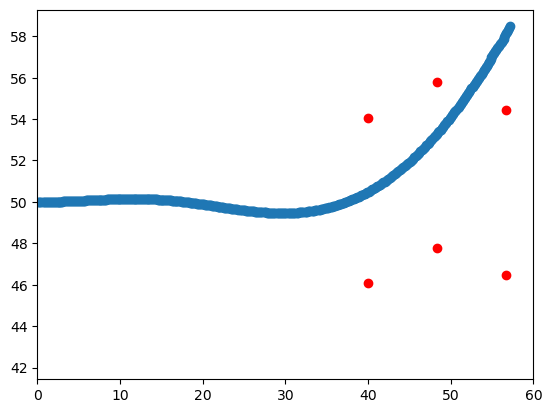

In [4]:
thrustCommandVal = 4.4
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))

iterations = 2000
iter = 0
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))

referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)
referencePointsDyn, referenceVelsDyn = ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)
for i in range(len(referencePointsDyn)):
    referencePointsDyn[i][0] = referencePointsDyn[i][0]-refStates[0]*np.sin(refStates[3])*i*drone.dt-midpoint
    referencePointsDyn[i][1] = referencePointsDyn[i][1]-refStates[0]*np.cos(refStates[3])*i*drone.dt-orignX

Acts, Bcts = drone.calculateCTSABMatrix(refStates, controlRef)
Aopt = np.eye(Acts.shape[0]+2)
#A = Aopt + env.calculateANumerical(stateRefFull, controlRef, env.rhoNom, step=10**-5)*env.dt
Aopt[0, 2] = drone.dt
Aopt[1, 5] = refStates[0]*drone.dt
Aopt[2:,2:] = Aopt[2:,2:]+Acts*drone.dt
Bopt = np.zeros([6,2])
Bopt[2:,0:1] = Bcts*drone.dt
alphaEst = refStates[1] - refStates[3]
Bopt[2, 1] = 1/drone.m*np.cos(alphaEst)*drone.dt
Bopt[5, 1] = 1/drone.m*np.sin(alphaEst)/refStates[0]*drone.dt
xstart = np.concatenate(([0.,0.], np.array(drone.stateEstimate) - np.array(refStates)))
xgoal = np.concatenate(([0.,100 - drone.stateEstimate[1]], [0.,0.,0.,0.]))
xsol, usol = ConvexMotionPlanning.localTrajOpt(Aopt, Bopt, tEnd, grid, referencePoints, referencePointsDyn, xstart, xgoal)
for i in range(np.min((tEnd, iterations-iter))):
    thrustCommand[iter+i] = usol[i][1] + thrustCommandVal 
    elivCommand[iter + i] = usol[i][0] + elivCommandRef
    xCommand[iter+i] = xsol[i][0]+refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
    yCommand[iter+i] = xsol[i][1]+refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
    refCommand[iter+i, :] = xsol[i][2:6].T + np.array(refStates)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xCommand[0:tEnd], yCommand[0:tEnd])
ax.scatter(drone.objects[0,:],drone.objects[1,:], color = "red" )
ax.set_xlim((0, 60))
open_loop_plots(0, tEnd,xCommand, yCommand,thrustCommand, elivCommand, drone)

/home/matthew/Documents/Flappy-Junco/plottingFunctions.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


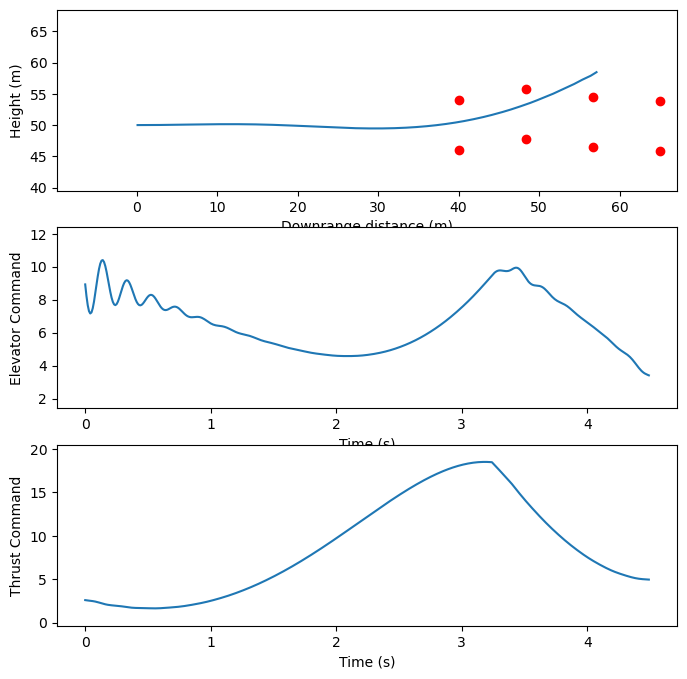